# Calculate Signal to Noise Reduction in Coherence from Snow Wetness

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.stats import gamma
from scipy.special import hyp2f1
import xarray as xa

## Gamma SNR

Use SNR decorrelation and the reduction in signal power due to wet snow to model decorrelation.

From: https://ieeexplore.ieee.org/document/9763376
Equation 4:

$$
\gamma_{SNR} = \frac{1}{\sqrt{(1 + S_{Primary}^{-1}) + (1 + S_{Secondary}^{-1})}}
$$

Equation 5:

$$
S = \frac{\beta^{0}(\theta) - \beta^{NEBN}(\theta)}{\beta^{0}(\theta)}
$$

In [27]:
def calc_S(beta, beta_naught):
    return (beta - beta_naught) / (beta)

def calc_p_SNR(s_primary, s_secondary):
    return 1 / np.sqrt((1 + s_primary ** -1) + (1 + s_secondary ** -1))

Conversion from beta to sigma naught per: https://www.intelligence-airbusds.com/files/pmedia/public/r465_9_tsxx-airbusds-tn-0049-radiometric_calculations_d1.pdf

Equation 5:
$$
\sigma^{0} = \beta^{0} * \sin \theta_{local} - NESZ
$$
Equation 6:
$$
NESZ = NEBN * \sin \theta_{local}
$$

In [2]:
def beta_from_sigma(sigma, loc_inc, NESZ):
    return (sigma + NESZ) / np.sin(loc_inc)
def NEBN_from_NESN(NESN, loc_inc):
    return NESN/ np.sin(loc_inc)

## Uavsar Noise Floor

Estimated by running receive sensors without sending any signal out.

Using Noise Equivalent Sigma Zero:
From uavsar calibration - -40 db at 20 degrees to -47 db at 38 degrees to -32 db at 65 degrees

In [9]:
def calc_NESZ(theta):
    theta = np.rad2deg(theta)
    # this equation is intended to match data from (https://uavsar.jpl.nasa.gov/science/documents/uavsar_polcal_ieee.pdf)
    # but is only approximately right because they don't have coefficents listed...
    # incidence angle control is due to the fact that measured values are beta_naught
    # which has to be converted to sigma_naught by NESN = NEBN * sin(inc)
    # from https://www.intelligence-airbusds.com/files/pmedia/public/r465_9_tsxx-airbusds-tn-0049-radiometric_calculations_d1.pdf
    return 0.021 * (theta - 38)**2 - 47

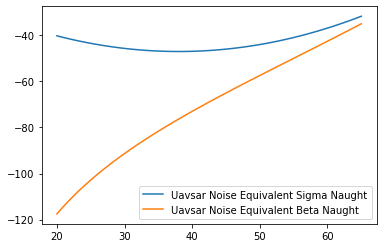

In [24]:
thetas = np.deg2rad(np.linspace(20, 65, 100))
NESZs = calc_NESZ(thetas)
NESBs = NEBN_from_NESN(NESZs, thetas)
plt.plot(np.rad2deg(thetas), NESZs, label = 'Uavsar Noise Equivalent Sigma Naught')
plt.plot(np.rad2deg(thetas), NESBs, label = 'Uavsar Noise Equivalent Beta Naught')
plt.legend()

## Reduction in Radar Amplitude from Snow Wetness

The attenuation of radar waves in snow is described by the imaginary component of
permittivity. For dry snow this essentially 0. For wetness we will explore a few
different parameterizations.

Tiuri et al. (1984):

From Figure 9/Equation 20:

$$
e^{''} = 0.9 * v_{h2O} + 7.2 * v_{h2O}^{2}
$$

and Bradford et al (2009):

$$
TODO
$$

With alpha being given by Equation 15 in Ulaby (1996):

$$
\alpha = \frac{2 * \pi}  {\lambda} * |(\sqrt{e^{''}})|
$$

In [13]:
def tiuri_snow_permittivity(density, water_vol = 0):
    ## from Tiuri et al (1984)
    # https://www.researchgate.net/publication/263579827_The_complex_dielectric_constant_of_snow_at_microwave_frequencies
    # at 1 GHz

    if np.any(density > 1):
        # convert density to relative to water
        density = density / 997


    perm_real = 1 + 1.7 * density + 0.7 * density **2
    perm_imag = (0.52*density + 0.62 * density **2) * 8e-4
    if water_vol > 0:
        perm_real = perm_real + 8.9 * water_vol + 70 * water_vol **2
        perm_imag = 0.9 * water_vol + 7.2 * water_vol**2
    return perm_real + perm_imag*1j

def alpha_calc(perm, radar_lambda = 0.23):
    alpha = 2 * np.pi / radar_lambda * np.abs(np.sqrt(perm).imag)
    return alpha

## Power Reduction with Depth and Wetness

We can use Equation 15 and 16 from Ulaby (1996) to calculate the reduction in power relative
 for two travel distance through snowpack would be:

$$
power_{dB} = 1 /(e^{\frac{depth*2*\alpha} {np.cos(\theta)}})
$$

In [20]:
def power_reduction(depth, alpha, theta = 0):
    return 1/np.e**(2* alpha *depth/np.cos(theta))

Text(0.5, 0, 'Snow Depth')

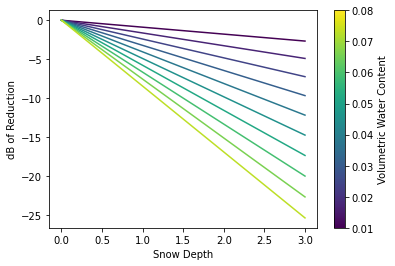

In [22]:
snow_depths = np.linspace(0, 3, 100)
volumetic_content = np.linspace(0.01, 0.08, 10)

for i, vc in enumerate(volumetic_content):
    e = tiuri_snow_permittivity(density = 300, water_vol = vc)
    alpha = alpha_calc(e)
    prs = power_reduction(snow_depths, alpha)
    prs_db = 10*np.log10(prs)

    c = mpl.colormaps['viridis'](i/len(volumetic_content))
    plt.plot(snow_depths, prs_db, color = c)
sm = plt.cm.ScalarMappable(cmap=mpl.colormaps['viridis'], norm=plt.Normalize(vmin=volumetic_content[0], vmax=volumetic_content[-1]))
plt.colorbar(sm, label = 'Volumetric Water Content')
plt.ylabel('dB of Reduction')
plt.xlabel('Snow Depth')

## Gamma SNR from dB of Reduction

Now we just combine the Uavsar Noise floor, the reduction in signal from snow wetness, and the relationship between the SNR and gamma SNR to calculate the reduction in coherence from signal power reduction in wet snow.

Text(0.5, 1.0, 'Modeled Decorrelation due to Wet Snow')

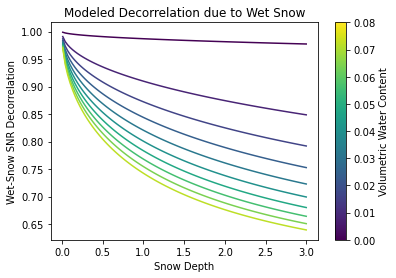

In [32]:
thetas = np.deg2rad(40)
NESZs = calc_NESZ(thetas)
NESBs = NEBN_from_NESN(NESZs, thetas)

snow_depths = np.linspace(0.01, 3, 100)
volumetic_content = np.linspace(0.0, 0.08, 10)

for i, vc in enumerate(volumetic_content):
    e = tiuri_snow_permittivity(density = 300, water_vol = vc)
    alpha = alpha_calc(e)
    prs = power_reduction(snow_depths, alpha)
    prs_db = 10*np.log10(prs)
    betas = beta_from_sigma(prs_db, loc_inc = thetas, NESZ = NESZs)
    Ss = calc_S(betas, NESBs)
    p_snr = 1- calc_p_SNR(Ss, Ss)

    c = mpl.colormaps['viridis'](i/len(volumetic_content))
    plt.plot(snow_depths,  p_snr, color = c)
sm = plt.cm.ScalarMappable(cmap=mpl.colormaps['viridis'], norm=plt.Normalize(vmin=volumetic_content[0], vmax=volumetic_content[-1]))
plt.colorbar(sm, label = 'Volumetric Water Content')
plt.ylabel('Wet-Snow SNR Decorrelation')
plt.xlabel('Snow Depth')
plt.title('Modeled Decorrelation due to Wet Snow')